In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configuration pour de jolis graphiques
sns.set(style="whitegrid")
%matplotlib inline

In [2]:
# Chargement des données
try:
    df = pd.read_csv('contribution.csv')
    print("Fichier chargé avec succès.")
except FileNotFoundError:
    # Génération de fausses données pour tester le code si vous n'avez pas encore le fichier
    print("⚠️ Fichier 'contribution.csv' non trouvé. Création de données exemples.")
    data = {
        'Nombre_Salaries': np.random.choice([0, 0, 0, 1, 5, 20, 100], 1000),
        'Salaire_Moyen': np.random.choice([0, 1500, 2000, 2500, 3500], 1000),
        'Nombre_Lieux_Activite': np.random.randint(0, 10, 1000),
        'Densité_par_habitant': np.random.uniform(10, 500, 1000)
    }
    df = pd.DataFrame(data)

# Sélection des features demandées
features = ['Densité_par_habitant', 'Nombre_Salaries', 'Salaire_Moyen', 'Nombre_Lieux_Activite']
df_clean = df[features].copy()

# Conversion en numérique (au cas où il y aurait des erreurs de format)
for col in features:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0)

print(f"Dimensions des données : {df_clean.shape}")
df_clean.head()

Fichier chargé avec succès.
Dimensions des données : (5337, 4)


,Densité_par_habitant,Nombre_Salaries,Salaire_Moyen,Nombre_Lieux_Activite
0,5.552227e+15,0,1,3
1,9.784121e+12,0,1,1
2,4.164128e+16,0,2,0
3,4.459325e+13,0,2,2
4,9.028946e+16,0,2,0


In [3]:
# 1. Calcul d'un score approximatif de contribution (Masse salariale)
# On ajoute +1 au salaire pour éviter de multiplier par 0 si l'info manque mais qu'il y a des salariés
df_clean['Score_Eco'] = df_clean['Nombre_Salaries'] * (df_clean['Salaire_Moyen'] + 1)

# 2. Définition des classes
# Cas 1 : Si le score est 0 (pas de salariés), c'est "Faible"
df_clean['Classe_Eco'] = 0

# Cas 2 : Pour ceux qui ont une activité, on coupe en deux (médiane) pour faire Moyen et Fort
mask_active = df_clean['Score_Eco'] > 0
median_active = df_clean.loc[mask_active, 'Score_Eco'].median()

df_clean.loc[mask_active & (df_clean['Score_Eco'] <= median_active), 'Classe_Eco'] = 1 # Moyenne
df_clean.loc[mask_active & (df_clean['Score_Eco'] > median_active), 'Classe_Eco'] = 2  # Forte

# Définition des labels pour l'affichage
labels_map = {0: 'Faible', 1: 'Moyenne', 2: 'Forte'}

print("Répartition des classes :")
print(df_clean['Classe_Eco'].map(labels_map).value_counts())

Répartition des classes :
Classe_Eco
Faible     5328
Moyenne       5
Forte         4
Name: count, dtype: int64


In [4]:
# Définition X et y
X = df_clean[features]
y = df_clean['Classe_Eco']

# Séparation : 80% entraînement, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Taille Train : {X_train.shape}")
print(f"Taille Test  : {X_test.shape}")

Taille Train : (4269, 4)
Taille Test  : (1068, 4)


In [5]:
# Création et entraînement du modèle
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print("Modèle entraîné avec succès !")

Modèle entraîné avec succès !


Précision globale (Accuracy) : 99.91%

Rapport de classification :
              precision    recall  f1-score   support

      Faible       1.00      1.00      1.00      1066
     Moyenne       0.50      1.00      0.67         1
       Forte       0.00      0.00      0.00         1

    accuracy                           1.00      1068
   macro avg       0.50      0.67      0.56      1068
weighted avg       1.00      1.00      1.00      1068



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


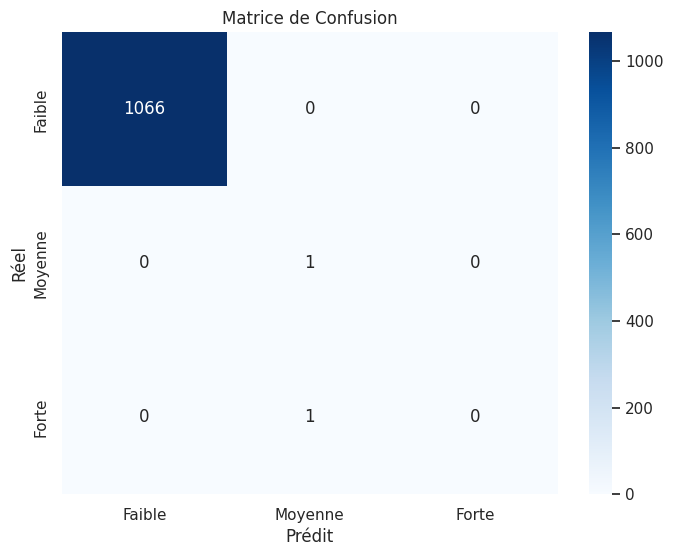

In [6]:
# Prédictions
y_pred = rf_model.predict(X_test)

# Métriques
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision globale (Accuracy) : {accuracy:.2%}\n")

print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=['Faible', 'Moyenne', 'Forte']))

# Matrice de confusion visuelle
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Faible', 'Moyenne', 'Forte'],
            yticklabels=['Faible', 'Moyenne', 'Forte'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion')
plt.show()

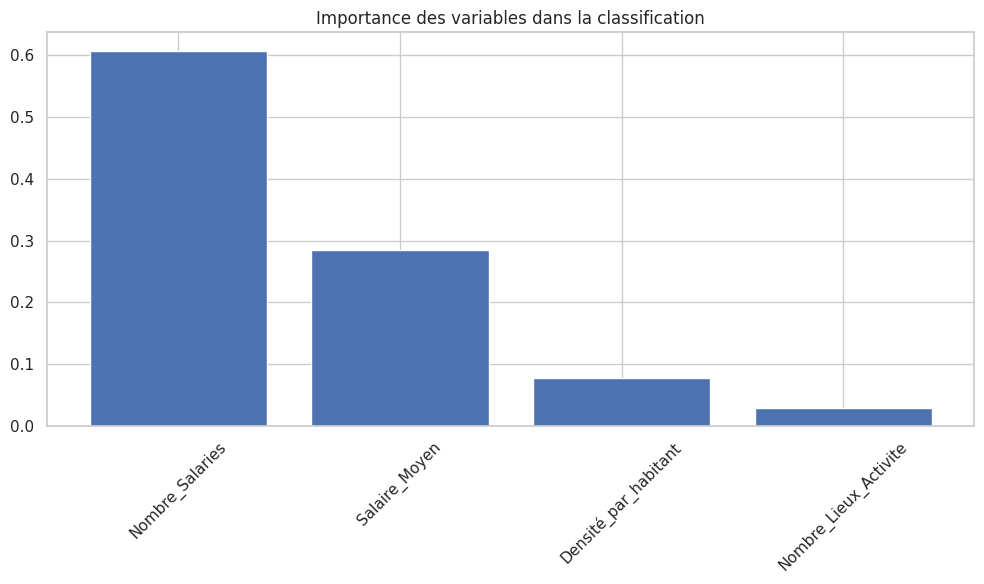

Classement des variables par importance :
- Nombre_Salaries : 0.6070
- Salaire_Moyen : 0.2852
- Densité_par_habitant : 0.0781
- Nombre_Lieux_Activite : 0.0296


In [7]:
# Récupération de l'importance des features
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Affichage graphique
plt.figure(figsize=(10, 6))
plt.title("Importance des variables dans la classification")
plt.bar(range(X.shape[1]), importances[indices], align="center", color="#4c72b0")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

# Affichage textuel
print("Classement des variables par importance :")
for i in indices:
    print(f"- {features[i]} : {importances[i]:.4f}")